In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
sys.path.append(str(project_root))

In [2]:
import pandas as pd
from src.data_processing import load_data, clean_data

df = load_data("../data/Telco_customer_churn.csv")
df = clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   object 
 6   Multiple Lines     7043 non-null   object 
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   object 
 9   Online Backup      7043 non-null   object 
 10  Device Protection  7043 non-null   object 
 11  Tech Support       7043 non-null   object 
 12  Streaming TV       7043 non-null   object 
 13  Streaming Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   object 
 16  Payment Method     7043 

In [3]:
df['Churn Value'].mean()

np.float64(0.2653698707936959)

<Axes: xlabel='Churn Value', ylabel='Monthly Charges'>

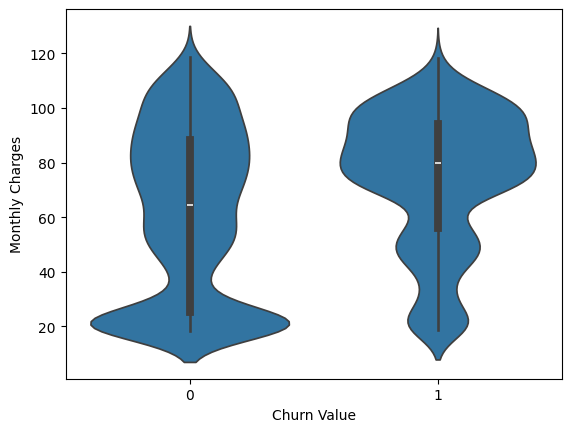

In [4]:
import seaborn as sns

sns.violinplot(data=df, x="Churn Value", y="Monthly Charges")

<Axes: xlabel='Contract', ylabel='count'>

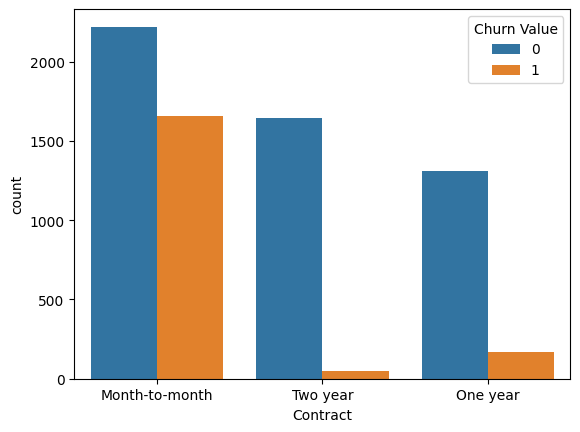

In [5]:
sns.countplot(data=df, x="Contract", hue="Churn Value")

<Axes: xlabel='Contract', ylabel='Churn Value'>

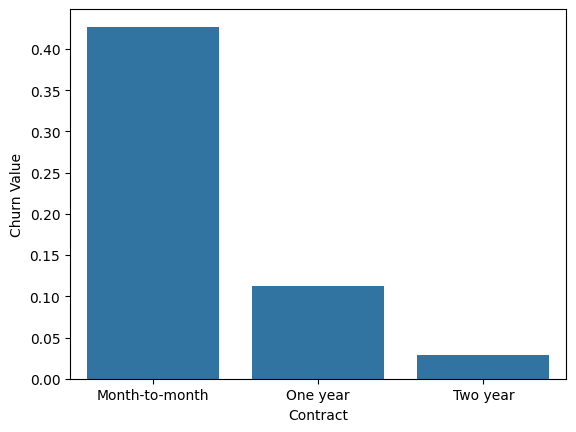

In [6]:
churn_rate = (
    df.groupby("Contract")["Churn Value"]
      .mean()
      .reset_index()
)

sns.barplot(data=churn_rate, x="Contract", y="Churn Value")

<Axes: xlabel='Online Security', ylabel='Churn Value'>

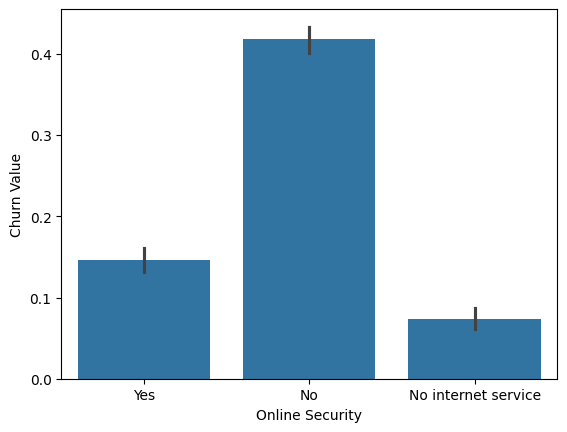

In [7]:
sns.barplot(data=df, x="Online Security", y="Churn Value")

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from src.features import build_preprocessor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from src.models import get_models
from sklearn.metrics import accuracy_score, roc_auc_score
from src.evaluation import evaluate_model
from src.evaluation import cv_pr_auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [9]:
X = df.drop("Churn Value", axis=1)
y = df["Churn Value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = build_preprocessor(df)
models = get_models()

trained_pipelines = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    trained_pipelines[name] = pipe

    results = evaluate_model(pipe, X_test, y_test)
    print(name, results)

logistic {'accuracy': 0.8055358410220014, 'roc_auc': 0.8488026040455707}
xgboost {'accuracy': 0.8055358410220014, 'roc_auc': 0.8570112893642305}
random_forest {'accuracy': 0.8048261178140526, 'roc_auc': 0.8498385388410964}
gbm_sklearn {'accuracy': 0.8055358410220014, 'roc_auc': 0.8556188483298458}


In [10]:
model_results = []

for name, pipe in trained_pipelines.items():
    mean_pr, std_pr = cv_pr_auc(pipe, X_train, y_train)
    model_results.append({
        "model": name,
        "pr_auc_mean": mean_pr,
        "pr_auc_std": std_pr
    })

results_df = pd.DataFrame(model_results).sort_values(
    "pr_auc_mean",
    ascending=False
)

results_df


,model,pr_auc_mean,pr_auc_std
3,gbm_sklearn,0.691497,0.017560
1,xgboost,0.689925,0.017211
0,logistic,0.680270,0.020603
2,random_forest,0.674321,0.013506


In [11]:
from sklearn.metrics import classification_report

threshold = 0.35

threshold_results = []

for name, pipe in trained_pipelines.items():
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    report = classification_report(
        y_test,
        y_pred,
        output_dict=True
    )

    threshold_results.append({
        "model": name,
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"]
    })

pd.DataFrame(threshold_results).sort_values("recall", ascending=False)


,model,precision,recall,f1
1,xgboost,0.566116,0.732620,0.638695
3,gbm_sklearn,0.574423,0.732620,0.643948
0,logistic,0.559499,0.716578,0.628370
2,random_forest,0.553719,0.716578,0.624709


In [12]:
from sklearn.metrics import average_precision_score

stability = []

for name, pipe in trained_pipelines.items():
    train_proba = pipe.predict_proba(X_train)[:, 1]
    test_proba = pipe.predict_proba(X_test)[:, 1]

    stability.append({
        "model": name,
        "train_pr_auc": average_precision_score(y_train, train_proba),
        "test_pr_auc": average_precision_score(y_test, test_proba),
        "gap": average_precision_score(y_train, train_proba) -
               average_precision_score(y_test, test_proba)
    })

pd.DataFrame(stability).sort_values("gap")


,model,train_pr_auc,test_pr_auc,gap
2,random_forest,0.692866,0.658723,0.034143
0,logistic,0.686209,0.645539,0.040671
3,gbm_sklearn,0.720426,0.673562,0.046864
1,xgboost,0.739938,0.672216,0.067722


In [13]:
final_model_name = "gbm_sklearn"
final_pipe = trained_pipelines[final_model_name]

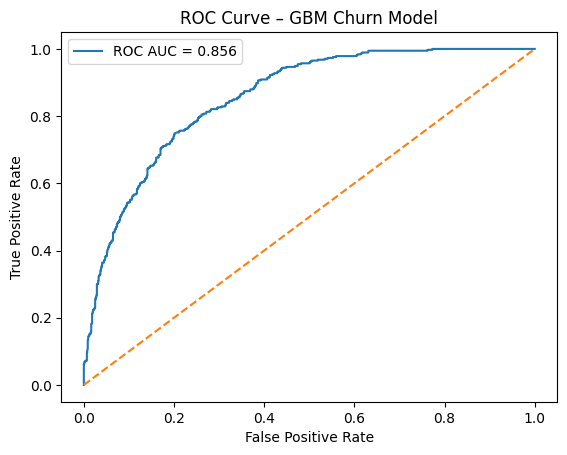

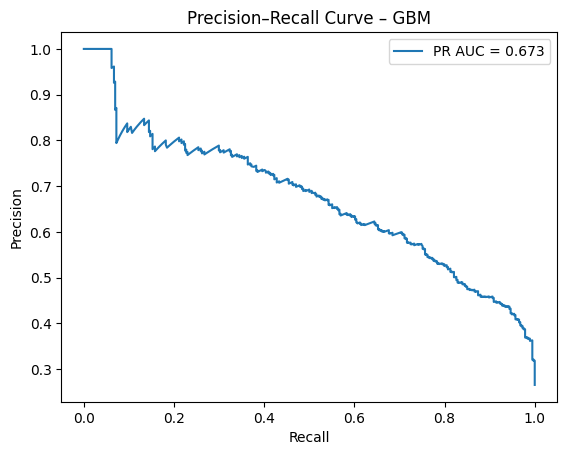

In [14]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_proba = final_pipe.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – GBM Churn Model")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – GBM")
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred_thresh = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_thresh)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh))

Confusion Matrix:
[[832 203]
 [100 274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85      1035
           1       0.57      0.73      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



In [16]:
#Final retrain
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

final_pipe.fit(X_full, y_full)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


C:\Users\evanr\Projects\telco-churn-retention\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 7044it [17:27,  6.72it/s]                                                              


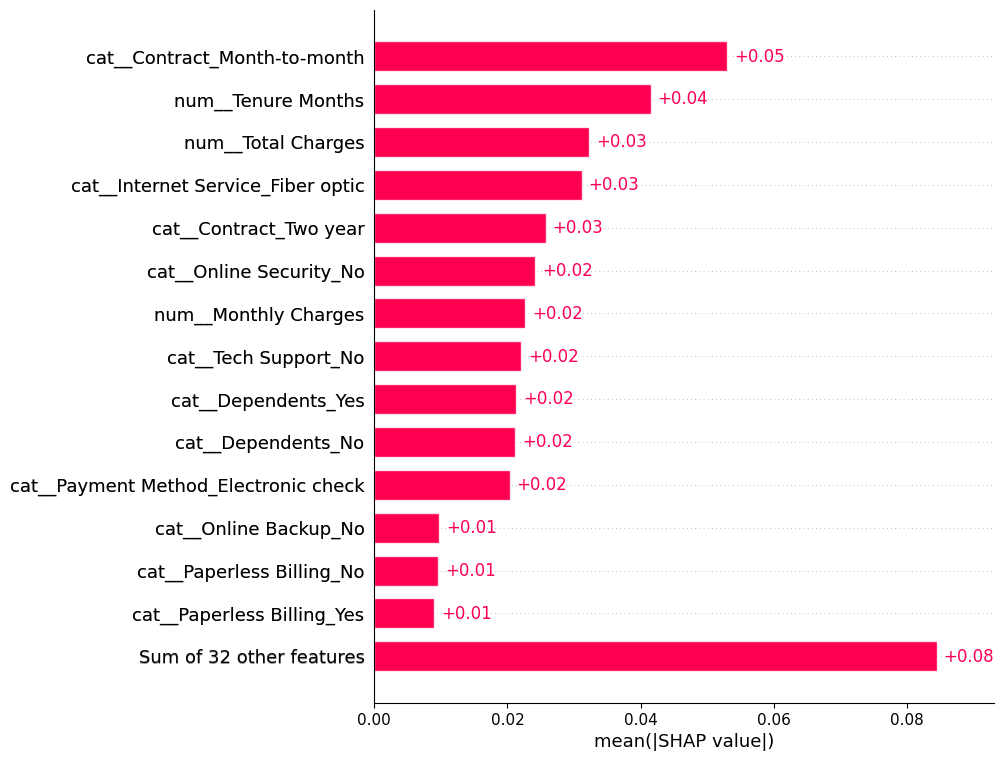

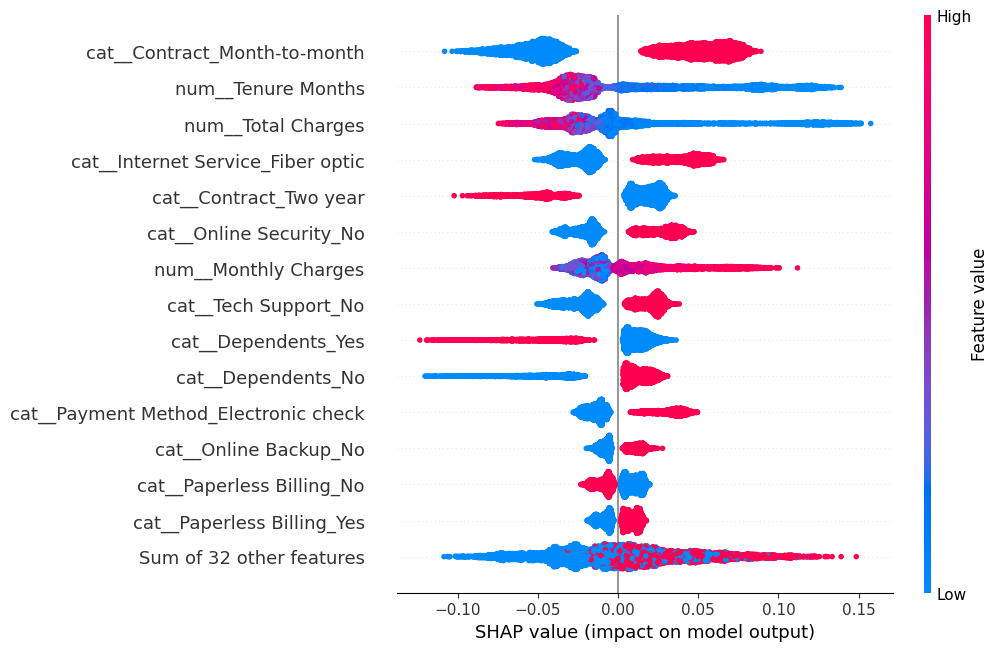

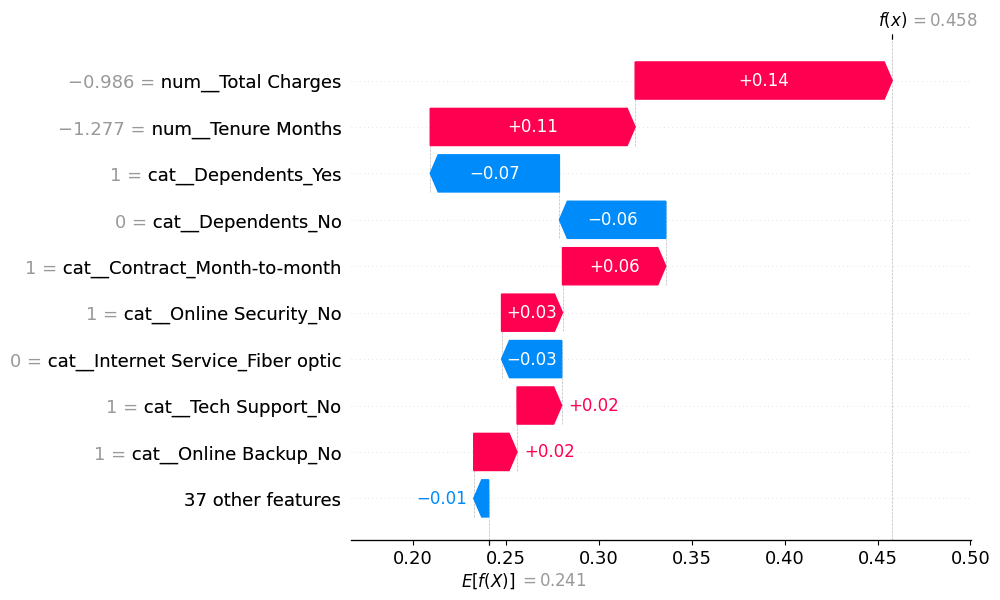

In [17]:
import shap

prep = final_pipe.named_steps["prep"]
model = final_pipe.named_steps["model"]

X_full_transformed = prep.transform(X_full)
feature_names = prep.get_feature_names_out()

#SHAP explainer
explainer = shap.Explainer(model.predict_proba, X_full_transformed, feature_names=feature_names)

#compute SHAP values for churns
shap_values = explainer(X_full_transformed)[:, :, 1]

#average feature importance
shap.plots.bar(shap_values, max_display=15)

#beeswarm
shap.plots.beeswarm(shap_values, max_display=15)

#single customer
customer_idx = 4
shap.plots.waterfall(shap_values[customer_idx])


In [18]:
#retention simulation
customer_value = df.loc[X_test.index, "Monthly Charges"] * 12
retention_cost = 50
retention_success_rate = 0.20

churn_prob = final_pipe.predict_proba(X_test)[:, 1]

#Expected Profit = P(churn) × P(save) × Customer Value − Retention Cost
expected_profit = (
    churn_prob
    * retention_success_rate
    * customer_value
    - retention_cost
)

target = expected_profit > 0

total_profit = expected_profit[target].sum()

print(f"Total Expected Profit: ${total_profit:,.2f}")
print(f"Customers Targeted: {target.sum()}")

Total Expected Profit: $28,754.91
Customers Targeted: 506
